# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [243]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pyparsing
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


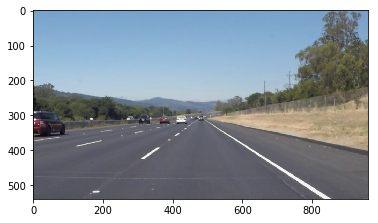

In [133]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [361]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def modified_draw_lines(img,lines,color=[255, 0, 0], thickness=10):
    
    line_image = np.zeros_like(img)
    for line in lines:
        if line is not None:
            cv2.line(img,*line,color,thickness)
    return cv2.addWeighted(img, 1.0, line_image, 0.95, 0.0)



def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

            

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

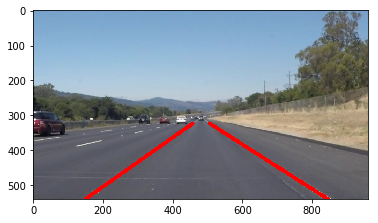

In [371]:
import os
##Read an image        
#image = mpimg.imread(input_path)
image = mpimg.imread('test_images/solidWhiteRight.jpg')
##Grab x and y size
ysize = image.shape[0]
xsize = image.shape[1]
#print (xsize,ysize)

##Copy into other image
image_copy = np.copy(image)
#plt.imshow(image_copy)

##Convert image to Gray Scale so that we can use Canny edge detection on it. 
"""Canny edge detection requires its input image as a grayscale."""

gray_image = grayscale(image_copy)
#plt.imshow(gray_image,cmap='gray')

##Use Gaussian Blur to remove noise with kernel size = 3
"""Gaussian Bluring is a technique used to remove gaussian noise from an image. 
    It removes high frequency content from an image.Gaussian filtering is done by convolving each point 
    in the input array with a Gaussian kernel and then summing them all to produce the output array."""
kernel_size = 3
blur_image = gaussian_blur(gray_image,kernel_size)

##Use Canny edge detection on Blur image
"""Multi Stage Algorithm.
    1. Noise reduction - First step is to use Gaussian Blur to remove noise which is used above.
    2. Find Intensity gradient of the image - Blurred image is then filtered with sobel kernel (Internally)
       to get Edge gradient Gx and Gy and then Gradient direction is calculated from Gx and Gy. It is perpendicular
       to the edge.
    3. Non-maximum suppression -  This removes pixels that are not considered to be part of an edge. 
       Hence, only thin lines (candidate edges) will remain.
    4. Hysteresis - Canny uses two threshold values.
                    a. If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
                    b. If a pixel gradient value is below the lower threshold, then it is rejected.
                    c  If the pixel gradient is between the two thresholds, 
                       then it will be accepted only if it is connected to a pixel that is above the upper threshold.
                       
    https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html
    https://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html"""
canny_image = canny(blur_image,60,180)
#plt.imshow(canny_image)


##Define Vertices for ROI
"""Y axis represents height (total rows) of an image and X axis represents width (total columns) of an image
   shape function returns height in 0th index and width in 1st index and channel in 2nd index."""
vertices = vertices = np.array([[(0,ysize),(450, 320), (490, 320), (xsize,ysize)]], dtype=np.int32)
interest_masked_image = region_of_interest(canny_image,vertices)

##Define the Hough transform parameters
"""Hough transform is used to detect shape in an image if the shape is represented by a math equation.
   For theoretical explanation https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
   Input image must be a binary image so we apply canny edge before using hough tranform.
   rho = x * cos(theta) + y * sin(theta)
   Suppose if we have 100 X 100 image then we need 180 columns to get accuracy of 1 degree angle.
   For rho, the max possible distance is diagonal length of an image.
   For 1 pixel accuracy, number of rows = diagonal length of an image
   This function will return end points of lines in an image.
   """
rho = 1                      # Pixel Accuracy
theta = np.pi/180            # Theta Accuracy
threshold = 70               # Minimum vote it should get to consider it as a line
min_line_length = 5          # Min length of a line. Line segments shorter than this is rejected.
max_line_gap = 300          #Maximum allowed gap between line segments to treat them as a single line.

#hough_image = hough_lines(interest_masked_image,rho,theta,threshold,min_line_length,max_line_gap)
#plt.imshow(hough_image)

lines = cv2.HoughLinesP(interest_masked_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
#print (lines)


# Draw the lines on the edge image
#combo_img = weighted_img(hough_image,image_copy)
#plt.imshow(combo_img)

##Uncomment above six commented lines to see hough lines on an image without interpolation/approximation

""" 
    Concept:
    We have one solid and dotted lines in images. Canny Edge function finds all edges in an image and using Region
    of Interest, we get our desired area (Polygon). Now we have to detect left and right lanes which are lines 
    in mathematical term. A line can be represented as y = mx + c or "rho = xcos(theta) + ysin(theta)" where rho is 
    the distance of a line from an origin of an image and theta is an angle between horizontal axis of an image to
    perpendicular of a line in Counter Clockwise direction. 
    
    Hough transform is the technique to find such lines in an image. So Hough transform function is used to detect lines
    in an image. This function returns start point(x1,y1) and end point(x2,y2) in an array [x1 y1 x2 y2].
    
    We can have many lines in an image (as we have dotted lane line). So the idea is to find each lines' slope and
    intercept and perform "Weighted" average of slope and intercept. Left line will have positive slope and right lines
    will have negative slopes. So we can combine right and left lines in different arrays and calculate average values
    separately.
    
    The average slope and intercept for both left and right lines are calculated in "Best_of_fit_line" method.
    Now we have average slope and intercept. By taking proper y1 and y2 value, we can calculate x1 and x2 values from
    
                                x1 = (y1 - intercept)/slope
                                x2 = (y2 - intercept)/slope
    
    y1,y2,x1,x2 values should be converted to integer as cv2.line function needs integer values.
    
    Finally, we will have two end point of a "REQUIRED" line.(x1,y1) and (x2,y2)
    
"""

"""
Following line calls modified_draw_lines function with two argument
    1. Original Image
    2. Call to best_of_fit_line function with original image and hough lines output.
        lane_line function calculate average slope and intercept by calling best_of_fit_line function.
        And then calculate integer values of start point and end point by calling get_start_end_points function
        Finally modified_draw_lines will draw a line from start point to end point using cv2.line function.
   
"""

last_image = modified_draw_lines(image_copy,best_of_fit_line(image_copy,lines))
plt.imshow(last_image)
#cv2.imwrite('test_images_output/frame4.jpg',cv2.cvtColor(last_image,cv2.COLOR_RGB2BGR))

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

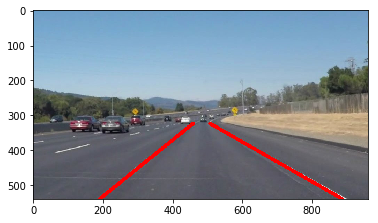

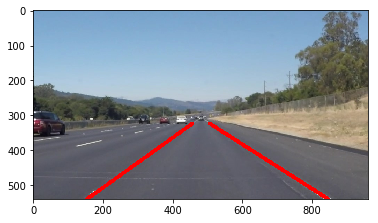

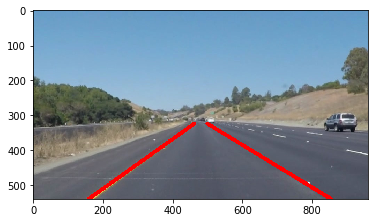

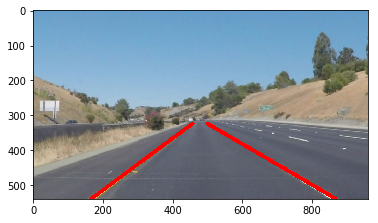

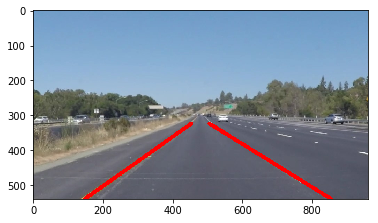

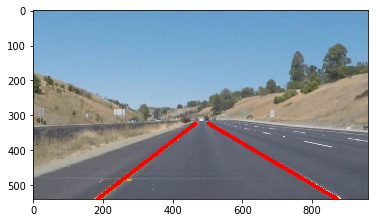

In [372]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


"""Following function calculates x1 and x2 values from y1,y2 and calculated average slope and intecept"""
def get_start_end_points(y1,y2,slope_intercept):
    
    if slope_intercept is None:
        return None
    slope,intercept = slope_intercept
    #Convert value of x and y to integer as cv2.Line function need integer values
    #print (slope)
    #print (y1)
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1,y1),(x2,y2))

"""Following function uses above two functions to make start point and end point tupple"""
def best_of_fit_line(img,lines):
    
    left_side_lines = []
    right_side_lines = []
    left_side_line_weight = []
    right_side_line_weight = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            ## Ignore Vertical Lines as it will give infinte slope value
            if x1 == x2:
                continue
            
            #Calculate slope as 'difference between y/difference between x'
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope) * x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            ##In General left lines have positive slope and right lines have negative slope.In 
            ##OpenCV/Numpy "y" increases from top to bottom so left lines will have negative
            ##slope and right lines will have positive slope.
            ##Append all lines which are having negative slopes to left_side_lines otherwise right_side_lines
            if slope < 0:
                left_side_lines.append((slope,intercept))
                left_side_line_weight.append((length))
            else:
                right_side_lines.append((slope,intercept))
                right_side_line_weight.append((length))

    #print (left_side_lines)
    #print (right_side_lines)
    #print (left_side_line_weight)
    #print (right_side_line_weight)
    
    ##Following two lines will find the average value for slope and intercept.
    ##dot method will perform dot product weight with slope and intercept individually.
    ##And then the value is divided by total weight value to get average value.
    ##Below is the simple example for future reference.
    ##
    #>>> a = [25,30,40] b = [(2,4),(1,1),(3,3)]
    #>>>np.dot(a,b)
    #array([200, 250])
    #>>> np.dot(a,b)/np.sum(a)
    #array([ 2.10526316,  2.63157895])
    
    left_avg_slope_intercept = np.dot(left_side_line_weight, left_side_lines) /np.sum(left_side_line_weight) if len(left_side_line_weight) > 0 else None
    right_avg_slope_intercept = np.dot(right_side_line_weight, right_side_lines) /np.sum(right_side_line_weight) if len(right_side_line_weight) > 0 else None
    
    #print (left_avg_slope_intercept)
    #print (right_avg_slope_intercept)
    
    
    
    #y1 = 500
    y1 = img.shape[0]
    y2 = y1 * 0.6
    
    left_lane = get_start_end_points(y1,y2,left_avg_slope_intercept)
    right_lane = get_start_end_points(y1,y2,right_avg_slope_intercept)
    
    return left_lane,right_lane


path = "test_images"
output_images = []
##Checking for each image in a directory test_image
for image_path in os.listdir(path):
        
        # create the full input path and read the file
        input_path = os.path.join(path, image_path)
        #print (input_path)
        
        ##Read an image        
        image = mpimg.imread(input_path)
        ##Grab x and y size
        ysize = image.shape[0]
        xsize = image.shape[1]

        ##Copy into other image
        image_copy = np.copy(image)
        #plt.imshow(image_copy)

        ##Convert image to Gray Scale
        gray_image = grayscale(image_copy)
        #plt.imshow(gray_image,cmap='gray')

        ##Use Gaussian Blur to remove noise with kernel size = 3
        kernel_size = 3
        blur_image = gaussian_blur(gray_image,kernel_size)

        ##Use Canny edge detection on Blur image
        canny_image = canny(blur_image,60,180)
        #plt.imshow(canny_image)


        ##Define Vertices for ROI
        vertices = vertices = np.array([[(0,ysize),(450, 320), (490, 320), (xsize,ysize)]], dtype=np.int32)
        interest_masked_image = region_of_interest(canny_image,vertices)

        ##Define the Hough transform parameters
        rho = 1
        theta = np.pi/180
        threshold = 50
        min_line_length = 5
        max_line_gap = 300

        hough_image = hough_lines(interest_masked_image,rho,theta,threshold,min_line_length,max_line_gap)
        #plt.imshow(hough_image)

        lines = cv2.HoughLinesP(interest_masked_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
        #print (lines)


        # Draw the lines on the edge image
        combo_img = weighted_img(image_copy,hough_image)
        #plt.imshow(combo_img)

        last_image = modified_draw_lines(image_copy,lane_lines(image_copy,lines))
        output_images.append(last_image)

        #plt.imshow(last_image)
output_path = 'test_images_output'

for (img,name) in zip(output_images,os.listdir(path)):
    input_path = os.path.join(path, image_path)
    #cv2.imwrite(os.path.join(output_path , name), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    plt.figure()
    
    plt.imshow(img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [274]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [ ]:
##Code to Store video in frames

#import cv2
#vidcap = cv2.VideoCapture('test_videos/challenge.mp4')
#success,image = vidcap.read()
#count = 0
#success = True
#while success:
#  success,image = vidcap.read()
#  print('Read a new frame: ', success)
#  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
#  count += 1

In [373]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    ##Read an image        
    image_frame = image
    ##Grab x and y size
    ysize = image_frame.shape[0]
    xsize = image_frame.shape[1]

    ##Copy into other image
    image_copy = np.copy(image_frame)
    #plt.imshow(image_copy)

    ##Convert image to Gray Scale
    gray_image = grayscale(image_copy)
    #plt.imshow(gray_image,cmap='gray')

    ##Use Gaussian Blur to remove noise with kernel size = 3
    kernel_size = 9
    blur_image = gaussian_blur(gray_image,kernel_size)

    ##Use Canny edge detection on Blur image
    canny_image = canny(blur_image,60,180)
    #plt.imshow(canny_image)


    ##Define Vertices for ROI
    vertices = vertices = np.array([[(0,ysize),(450, 320), (490, 320), (xsize,ysize)]], dtype=np.int32)
    interest_masked_image = region_of_interest(canny_image,vertices)

    ##Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 75
    min_line_length = 5
    max_line_gap = 300

    hough_image = hough_lines(interest_masked_image,rho,theta,threshold,min_line_length,max_line_gap)
    #plt.imshow(hough_image)

    lines = cv2.HoughLinesP(interest_masked_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    #print (lines)

    # Draw the lines on the edge image
    #combo_img = weighted_img(image_copy,hough_image)
    #plt.imshow(combo_img)

    result = modified_draw_lines(image_copy,lane_lines(image_copy,lines))
        
    
    return result

Let's try the one with the solid white lane on the right first ...

In [366]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:05<00:00, 40.36it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.33 s, sys: 887 ms, total: 4.22 s
Wall time: 6.08 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [367]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [368]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



100%|█████████▉| 681/682 [00:15<00:00, 43.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.2 s, sys: 2.27 s, total: 12.5 s
Wall time: 16.2 s


In [369]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [370]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/126 [00:00<?, ?it/s]

OverflowError: cannot convert float infinity to integer

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))